In [1]:
model_checkpoint = "microsoft/resnet-50" # pre-trained model from which to fine-tune
batch_size = 32 # batch size for training and evaluation

In [2]:
from huggingface_hub import notebook_login

# notebook_login()

d:\Research_CNN\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir=r"D:\Research_CNN\archive")

In [5]:
import evaluate

metric = evaluate.load("accuracy")

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 10432
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 32
    })
    test: Dataset({
        features: ['image'],
        num_rows: 1248
    })
})

In [7]:
example = dataset["train"][10]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1724x1581>}

In [8]:
dataset["train"].features

{'image': Image(mode=None, decode=True)}

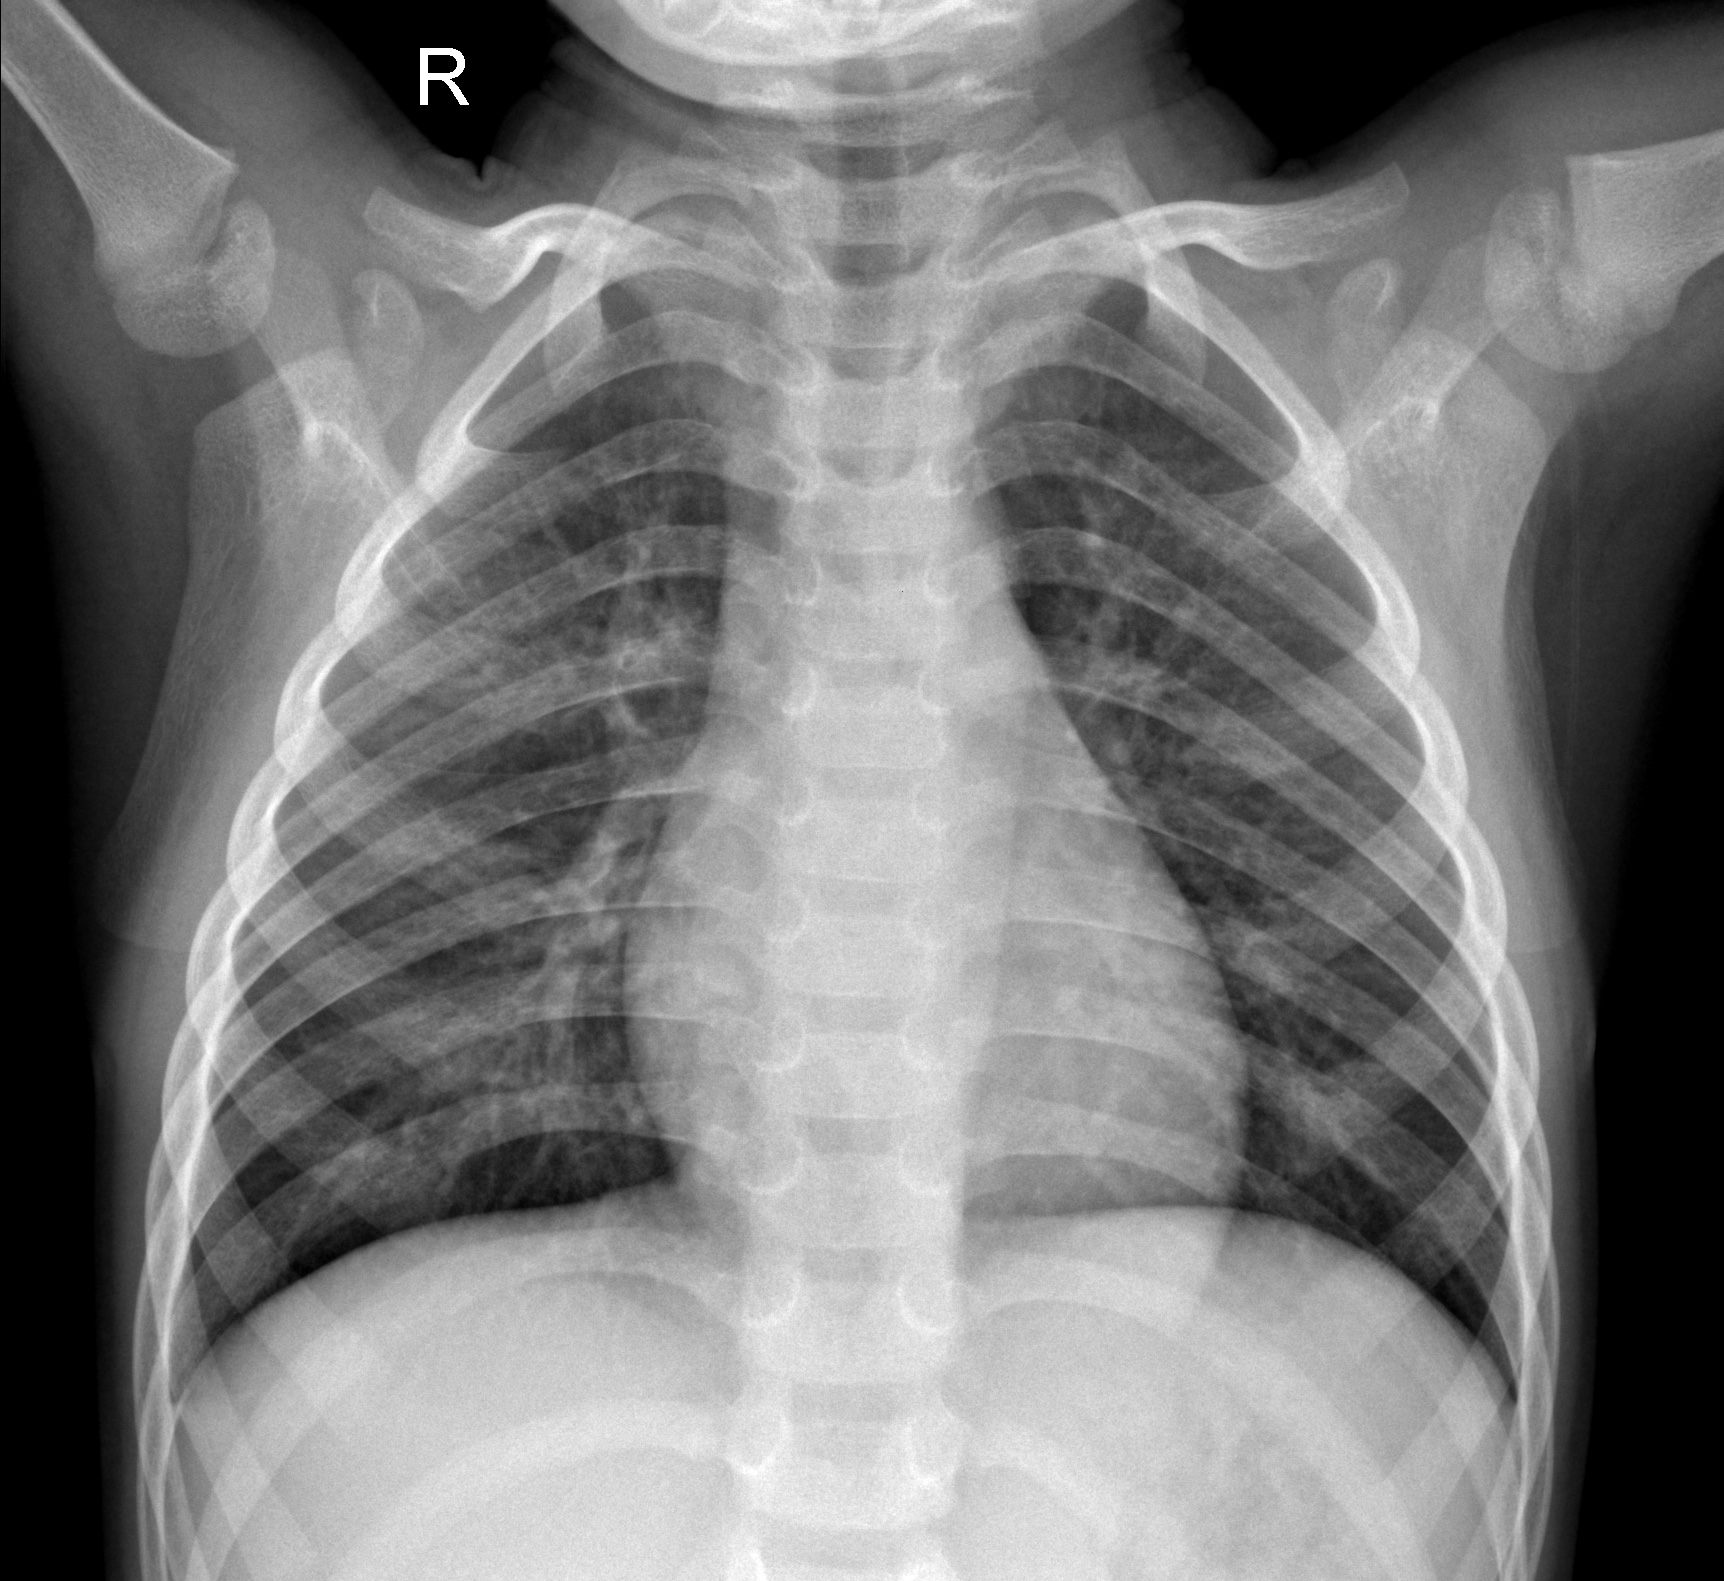

In [9]:
example['image']

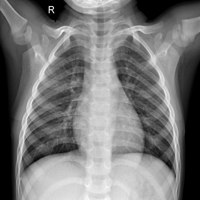

In [10]:
example['image'].resize((200, 200))

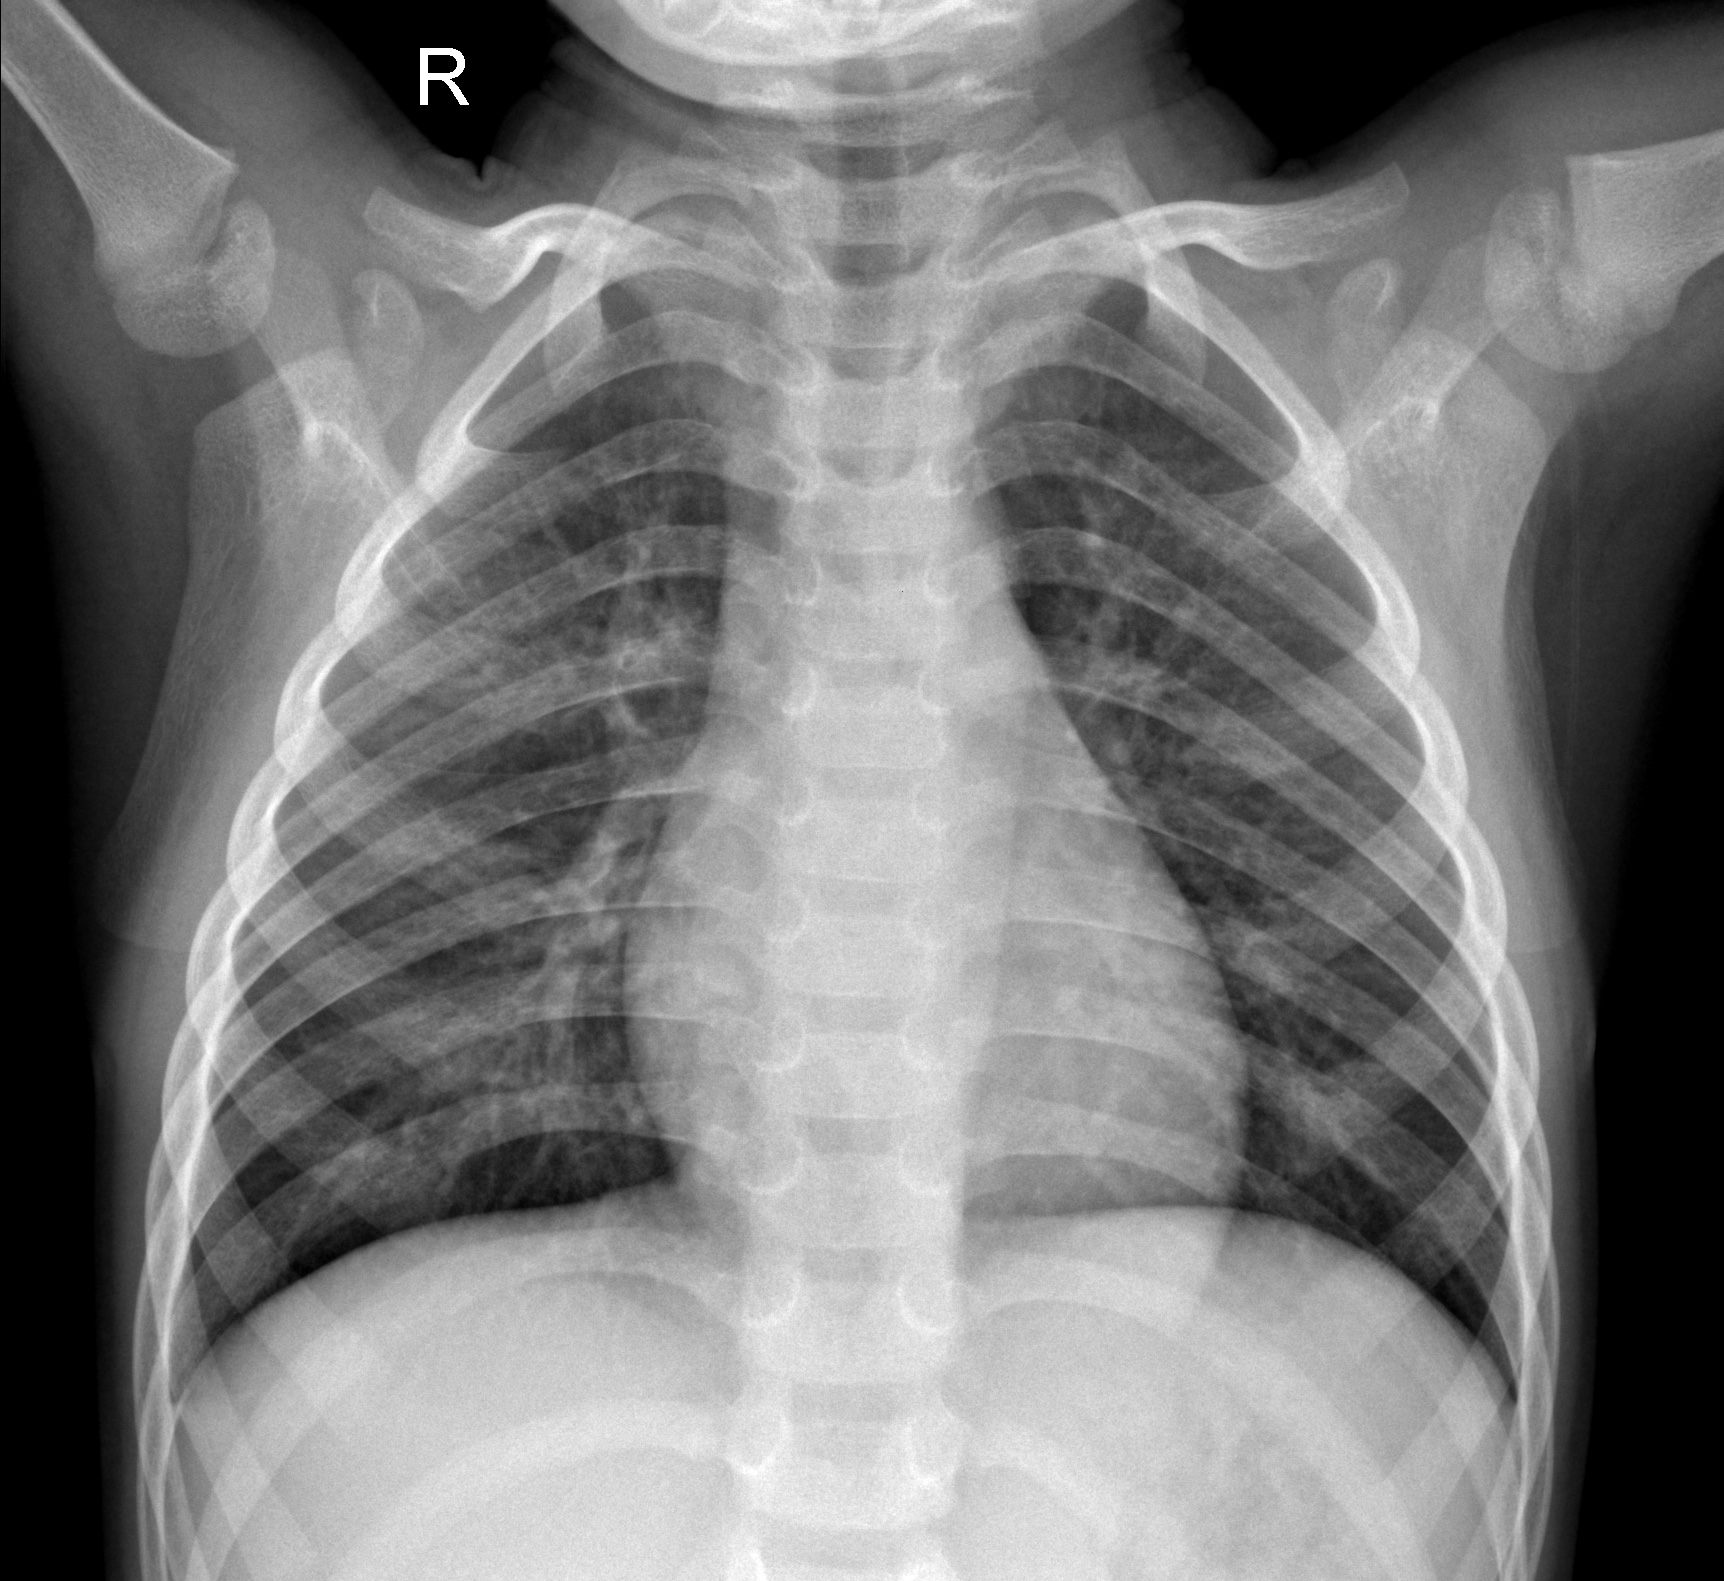

In [11]:
example['image']

In [12]:
dataset["train"].features["image"]

Image(mode=None, decode=True)

In [13]:
from datasets import load_dataset

# Load dataset - imagefolder automatically creates labels from folder structure
dataset = load_dataset("imagefolder", data_dir=r"D:\Research_CNN\archive")

# Check if labels already exist
print("Dataset structure:", dataset)
print("Features:", dataset["train"].features)
print("Sample:", dataset["train"][0])

# If labels don't exist, you need to load with split info
# The imagefolder loader should automatically detect folder structure
# Make sure your directory structure is like:
# archive/
#   ├── train/
#   │   ├── class1/
#   │   │   ├── img1.jpg
#   │   │   └── img2.jpg
#   │   └── class2/
#   │       └── img3.jpg
#   ├── validation/
#   └── test/

# If automatic detection didn't work, try this approach:
# Load dataset with explicit structure
dataset = load_dataset(
    "imagefolder",
    data_dir=r"D:\Research_CNN\archive",
    drop_labels=False  # Keep labels from folder names
)

# If you need to access the file path, use this method:
def add_label_from_path(example, idx):
    # Access the underlying file path from the dataset
    # This requires getting the path from the dataset's internal structure
    return example

# Alternatively, if imagefolder detected labels automatically:
if "label" in dataset["train"].features:
    labels = dataset["train"].features["label"].names
    label2id = {label: i for i, label in enumerate(labels)}
    id2label = {i: label for i, label in enumerate(labels)}
    
    print("Labels:", labels)
    print("label2id:", label2id)
    print("id2label:", id2label)
else:
    print("Labels were not automatically detected. Check your directory structure.")

Dataset structure: DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 10432
    })
    validation: Dataset({
        features: ['image'],
        num_rows: 32
    })
    test: Dataset({
        features: ['image'],
        num_rows: 1248
    })
})
Features: {'image': Image(mode=None, decode=True)}
Sample: {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858 at 0x1AB09247290>}
Labels: ['NORMAL', 'PNEUMONIA']
label2id: {'NORMAL': 0, 'PNEUMONIA': 1}
id2label: {0: 'NORMAL', 1: 'PNEUMONIA'}


In [14]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label
    #id2label[2]

In [15]:
from transformers import AutoImageProcessor

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor 

d:\Research_CNN\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--microsoft--resnet-50. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the 

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [16]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [17]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [18]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [19]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=L size=1080x584>,
 'label': 1,
 'pixel_values': tensor([[[1.0331, 1.0331, 1.0331,  ..., 0.6392, 0.6563, 0.6563],
          [1.0502, 1.0502, 1.0502,  ..., 0.5193, 0.5022, 0.5364],
          [1.0159, 1.0502, 1.0331,  ..., 0.5536, 0.5364, 0.5364],
          ...,
          [0.7762, 0.8104, 0.7933,  ..., 0.8104, 0.8104, 0.8276],
          [0.7591, 0.7933, 0.8104,  ..., 0.8104, 0.8276, 0.8447],
          [0.8104, 0.8618, 0.8618,  ..., 0.8104, 0.8104, 0.8104]],
 
         [[1.1856, 1.1856, 1.1856,  ..., 0.7829, 0.8004, 0.8004],
          [1.2031, 1.2031, 1.2031,  ..., 0.6604, 0.6429, 0.6779],
          [1.1681, 1.2031, 1.1856,  ..., 0.6954, 0.6779, 0.6779],
          ...,
          [0.9230, 0.9580, 0.9405,  ..., 0.9580, 0.9580, 0.9755],
          [0.9055, 0.9405, 0.9580,  ..., 0.9580, 0.9755, 0.9930],
          [0.9580, 1.0105, 1.0105,  ..., 0.9580, 0.9580, 0.9580]],
 
         [[1.4025, 1.4025, 1.4025,  ..., 1.0017, 1.0191, 1.0191],
   

In [20]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint, 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-pneumonia",
    remove_unused_columns=False,
    eval_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [23]:
import numpy as np

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [24]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_16172\850056282.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [26]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

d:\Research_CNN\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


d:\Research_CNN\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
d:\Research_CNN\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Processing Files (2 / 2): 100%|██████████| 94.3MB / 94.3MB, 31.1MB/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  


***** train metrics *****
  epoch                    =         3.0
  total_flos               = 556999726GF
  train_loss               =      0.4484
  train_runtime            =  1:29:46.39
  train_samples_per_second =       5.229
  train_steps_per_second   =       0.041


In [27]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

d:\Research_CNN\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.7481
  eval_loss               =     0.3207
  eval_runtime            = 0:01:15.01
  eval_samples_per_second =     13.918
  eval_steps_per_second   =       0.44


In [28]:
trainer.push_to_hub()

Processing Files (2 / 2): 100%|██████████| 94.3MB / 94.3MB, 6.51MB/s  
New Data Upload: |          |  0.00B /  0.00B,  0.00B/s  


CommitInfo(commit_url='https://huggingface.co/Adi-19/resnet-50-finetuned-pneumonia/commit/6b55b433771ac07b5907b1f5e1b8b05523e2e091', commit_message='End of training', commit_description='', oid='6b55b433771ac07b5907b1f5e1b8b05523e2e091', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Adi-19/resnet-50-finetuned-pneumonia', endpoint='https://huggingface.co', repo_type='model', repo_id='Adi-19/resnet-50-finetuned-pneumonia'), pr_revision=None, pr_num=None)

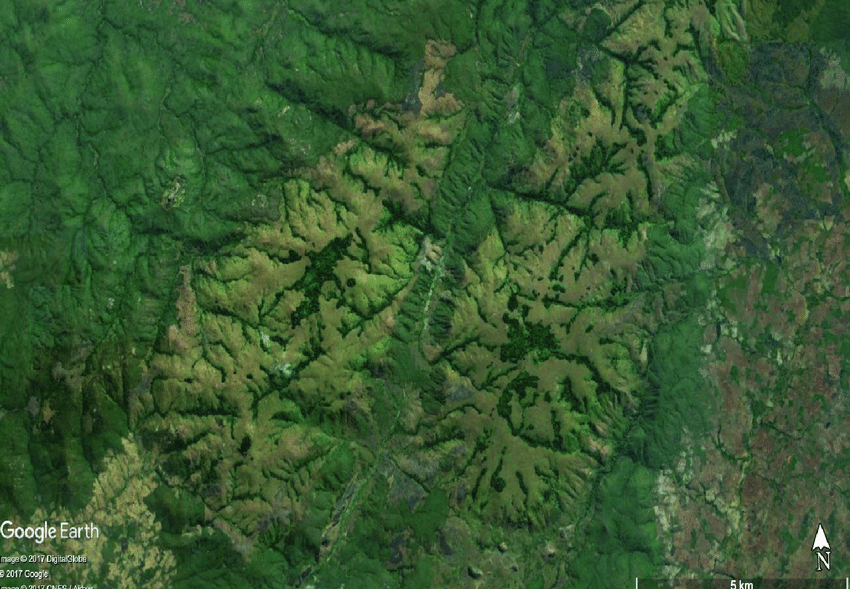

In [29]:
from PIL import Image
import requests

url = 'https://huggingface.co/nielsr/convnext-tiny-finetuned-eurostat/resolve/main/forest.png'
image = Image.open(requests.get(url, stream=True).raw)
image

In [30]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "Adi-19/resnet-50-finetuned-pneumonia"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

d:\Research_CNN\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--Adi-19--resnet-50-finetuned-pneumonia. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [31]:
# prepare image for the model
encoding = image_processor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [32]:
import torch

# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

In [33]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: PNEUMONIA


In [36]:
from transformers import pipeline

pipe = pipeline("image-classification", "Adi-19/resnet-50-finetuned-pneumonia")

Device set to use cpu


In [37]:
pipe(image)

[{'label': 'PNEUMONIA', 'score': 1.0},
 {'label': 'NORMAL', 'score': 2.7881091213544096e-08}]

In [38]:
pipe = pipeline("image-classification", 
                model=model,
                feature_extractor=image_processor)

Device set to use cpu


In [39]:
pipe(image)

[{'label': 'PNEUMONIA', 'score': 1.0},
 {'label': 'NORMAL', 'score': 2.7881091213544096e-08}]